## SMM Estimation - Simulated Method of Moments

In [1]:
import ast
import numpy as np
import scipy as sp
import scipy.stats as sts
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from broadcastplatform import Platform
import time
import itertools

In [2]:
generic = lambda x:ast.literal_eval(x)
conv = {'StartOpinion': generic,
             'Density': generic,
          'AveOpinion':generic,
              'AveStd':generic,
            'PosRatio':generic,
     'ExpressionRatio':generic}

In [3]:
samples = pd.read_csv('SampleRecord.txt',converters=conv)
sample_0 = samples.loc[0]
sample_0

RoomID                                                        485503
Time1                                                     2018-10-21
Time2                                                           21:3
Population                                                       848
StartOpinion       [0.6980678229578181, 0.15185191051103036, -0.3...
Density            {1: 464, 2: 183, 3: 67, 4: 47, 5: 23, 6: 11, 7...
AveOpinion         [0.29385934591975094, 0.44557168991311513, 0.3...
AveStd             [0.5286719173096472, 0.33604725030305344, 0.71...
PosRatio           [0.75, 0.8, 0.8333333333333334, 0.5, 0.25, 0.6...
ExpressionRatio    [0.0047169811320754715, 0.00589622641509434, 0...
Name: 0, dtype: object

In [4]:
count_dict = sample_0['Density']
count_array = []
for k in count_dict:
    count_array += (count_dict[k]*[k])
density_array = np.array(count_array)*2/len(sample_0['AveOpinion'])

In [5]:
unique_density = np.unique(density_array)
unique_density

array([0.00333333, 0.00666667, 0.01      , 0.01333333, 0.01666667,
       0.02      , 0.02333333, 0.02666667, 0.03      , 0.03333333,
       0.03666667, 0.04      , 0.04333333, 0.04666667, 0.05333333,
       0.05666667, 0.10666667, 0.11      , 0.12666667])

In [6]:
bin_edges_1 = np.append(unique_density[:14], [unique_density[13]+unique_density[0],unique_density[15]+unique_density[0],
                                              unique_density[18]+unique_density[0]])
bin_edges_1

array([0.00333333, 0.00666667, 0.01      , 0.01333333, 0.01666667,
       0.02      , 0.02333333, 0.02666667, 0.03      , 0.03333333,
       0.03666667, 0.04      , 0.04333333, 0.04666667, 0.05      ,
       0.06      , 0.13      ])

In [7]:
bin_edges_2 = np.append(unique_density[:14], [unique_density[13]+unique_density[0],unique_density[15]+unique_density[0]])
bin_edges_2

array([0.00333333, 0.00666667, 0.01      , 0.01333333, 0.01666667,
       0.02      , 0.02333333, 0.02666667, 0.03      , 0.03333333,
       0.03666667, 0.04      , 0.04333333, 0.04666667, 0.05      ,
       0.06      ])

In [8]:
bin_edges_3 = np.append(unique_density[:14], [unique_density[13]+unique_density[0]])
bin_edges_3

array([0.00333333, 0.00666667, 0.01      , 0.01333333, 0.01666667,
       0.02      , 0.02333333, 0.02666667, 0.03      , 0.03333333,
       0.03666667, 0.04      , 0.04333333, 0.04666667, 0.05      ])

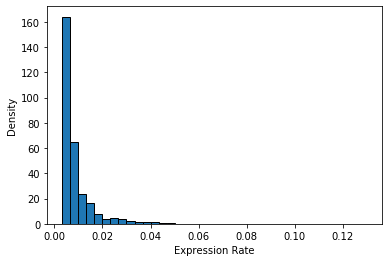

In [9]:
density_count, density_bins, density_ignored = plt.hist(density_array, bins = bin_edges_1,
                                                        density=True, edgecolor='k')
plt.xlabel('Expression Rate')
plt.ylabel('Density')
plt.show()

In [7]:
# Using MLE to estimate
def NLL(paras, dist, xvals):
    '''
    --------------------------------------------------------------------
    Calculate the negative log-likelihood value from the data with 
    the assumed distribution
    --------------------------------------------------------------------
    INPUTS:
    paras = (N,) vector, values of parameters 
    xvals = (N,) vector, values of the random variable
    dist  = function (callable), name for the distribution 
            (should have the member logpdf(x, ...))   
    
    RETURNS: negative log-likelihood value
    --------------------------------------------------------------------
    '''
    nll = sum(dist.logpdf(xvals, *paras, loc=min(xvals)*(1-0.30)))*(-1) 
    return nll 

# calculate the GA MLE to estimate the parameter for entertainment parameters
density_mean = np.mean(density_array)
density_var = np.var(density_array)
alpha_init = (((1-density_mean)/density_var)-(1/density_mean))*(density_mean**2)
beta_init = alpha_init*((1/density_mean)-1)
Beta_MLE_result_1 = sp.optimize.minimize(NLL, np.array((alpha_init, beta_init)), 
                                   args = (sp.stats.beta, density_array), 
                                   tol=1e-50, method="SLSQP", options={'maxiter': 1000}, 
                                   bounds=[(1e-10,None),(1e-10,None)])
print(Beta_MLE_result_1) 

     fun: -3593.9850808275582
     jac: array([0.00296021, 0.00531006])
 message: 'Optimization terminated successfully.'
    nfev: 149
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([  0.78114435, 143.250829  ])


In [11]:
# calculate the GA MLE to estimate the parameter for entertainment parameters
density_mean = np.mean(density_array[:-3])
density_var = np.var(density_array[:-3])
alpha_init = (((1-density_mean)/density_var)-(1/density_mean))*(density_mean**2)
beta_init = alpha_init*((1/density_mean)-1)
Beta_MLE_result_2 = sp.optimize.minimize(NLL, np.array((alpha_init, beta_init)), 
                                   args = (sp.stats.beta, density_array[:-3]), 
                                   tol=1e-50, method="SLSQP", options={'maxiter': 1000}, 
                                   bounds=[(1e-10,None),(1e-10,None)])
print(Beta_MLE_result_2) 

     fun: -3635.6697079098753
     jac: array([0.00314331, 0.00320435])
 message: 'Optimization terminated successfully.'
    nfev: 144
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([  0.84290592, 166.81428907])


In [19]:
NLL(Beta_MLE_result_2.x, sts.beta, density_array)

-3590.127684189683

In [12]:
# Using GMM to estimate
def GMM_model_moments(alpha, beta, bin_edges): 
    return sp.stats.beta.cdf(bin_edges[1:], alpha, beta, loc=min(bin_edges)*(1-0.30))-\
           sp.stats.beta.cdf(bin_edges[:-1], alpha, beta, loc=min(bin_edges)*(1-0.30))

# define error function
def GMM_err_vec(data_moments, alpha, beta, bin_edges, simple):
    model_moments = GMM_model_moments(alpha, beta, bin_edges)
    if simple:
        return  model_moments - data_moments
    else:
        return (model_moments - data_moments) / data_moments
    
# define criterion function
def GMM_criterion(paras, *args):
    alpha, beta = paras
    data_moments, bin_edges, simple, W = args
    error_vec = GMM_err_vec(data_moments, alpha, beta, bin_edges, simple)
    return error_vec.T @ W @ error_vec
            
density_data_moments_1 = np.histogram(density_array, 
bins = bin_edges_1, weights=[1/len(density_array)]*len(density_array))[0]
                                    
W_fixed_1 = np.diag(density_data_moments_1)
density_mean = np.mean(density_array)
density_var = np.var(density_array)
alpha_init = (((1-density_mean)/density_var)-(1/density_mean))*(density_mean**2)
beta_init = alpha_init*((1/density_mean)-1)
                                    
Beta_GMM_result_1 = sp.optimize.minimize(GMM_criterion, np.array((alpha_init, beta_init)),
                                args=(density_data_moments_1, bin_edges_1, False, W_fixed_1), 
                                tol = 1e-50, method="SLSQP", options={'maxiter': 1000}, 
                                bounds=[(1e-10, None), (1e-10, None)])
Beta_GMM_result_1

     fun: 0.08321708396935486
     jac: array([2.92249024e-06, 3.16277146e-06])
 message: 'Optimization terminated successfully.'
    nfev: 297
     nit: 45
    njev: 45
  status: 0
 success: True
       x: array([  1.10345289, 243.09299208])

In [13]:
NLL(Beta_GMM_result_1.x, sts.beta, density_array)

-3539.3131523978636

In [20]:
density_data_moments_2 = np.histogram(density_array, 
bins = bin_edges_2, weights=[1/len(density_array)]*len(density_array))[0]
                                    
W_fixed_2 = np.diag(density_data_moments_2)
density_mean = np.mean(density_array)
density_var = np.var(density_array)
alpha_init = (((1-density_mean)/density_var)-(1/density_mean))*(density_mean**2)
beta_init = alpha_init*((1/density_mean)-1)
                                    
Beta_GMM_result_2 = sp.optimize.minimize(GMM_criterion, np.array((alpha_init, beta_init)),
                                args=(density_data_moments_2, bin_edges_2, False, W_fixed_2), 
                                tol = 1e-50, method="SLSQP", options={'maxiter': 1000}, 
                                bounds=[(1e-10, None), (1e-10, None)])
Beta_GMM_result_2

     fun: 0.07968083420321395
     jac: array([-9.45292413e-07,  1.11665577e-06])
 message: 'Optimization terminated successfully.'
    nfev: 198
     nit: 36
    njev: 36
  status: 0
 success: True
       x: array([  1.10360434, 243.137962  ])

In [21]:
NLL(Beta_GMM_result_2.x, sts.beta, density_array)

-3539.270231443192

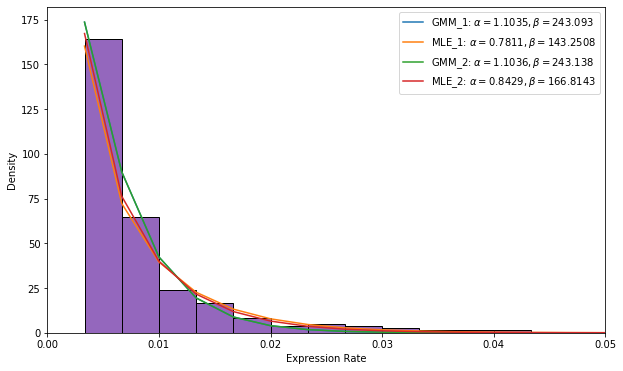

In [36]:
plt.plot(bin_edges_1, 
         sp.stats.beta.pdf(bin_edges_1, Beta_GMM_result_1.x[0], Beta_GMM_result_1.x[1],loc=min(bin_edges_1)*(1-0.30)),
         linewidth=1.5, 
         label=r'GMM_1: $\alpha={}, \beta={}$'.format(round(Beta_GMM_result_1.x[0],4),
                                                    round(Beta_GMM_result_1.x[1],4)))
plt.plot(bin_edges_1, 
         sp.stats.beta.pdf(bin_edges_1, a=Beta_MLE_result_1.x[0], b=Beta_MLE_result_1.x[1], loc=min(bin_edges_1)*(1-0.30)),
         linewidth=1.5, 
         label=r'MLE_1: $\alpha={}, \beta={}$'.format(round(Beta_MLE_result_1.x[0],4),
                                                    round(Beta_MLE_result_1.x[1],4)))
plt.plot(bin_edges_2, 
         sp.stats.beta.pdf(bin_edges_2, Beta_GMM_result_2.x[0], Beta_GMM_result_2.x[1],loc=min(bin_edges_2)*(1-0.30)),
         linewidth=1.5, 
         label=r'GMM_2: $\alpha={}, \beta={}$'.format(round(Beta_GMM_result_2.x[0],4),
                                                    round(Beta_GMM_result_2.x[1],4)))
plt.plot(bin_edges_2, 
         sp.stats.beta.pdf(bin_edges_2, a=Beta_MLE_result_2.x[0], b=Beta_MLE_result_2.x[1], loc=min(bin_edges_2)*(1-0.30)),
         linewidth=1.5, 
         label=r'MLE_2: $\alpha={}, \beta={}$'.format(round(Beta_MLE_result_2.x[0],4),
                                                    round(Beta_MLE_result_2.x[1],4)))
density_count, density_bins, density_ignored = plt.hist(density_array, bins = bin_edges_1,
                                                        density=True, edgecolor='k')
plt.rcParams['figure.figsize'] = (9,6)
plt.xlim([0,0.05])
plt.xlabel('Expression Rate')
plt.ylabel('Density')
plt.legend()
plt.savefig('estimation pictures/'+'beta estimation')
plt.show()

MLE_1 yields better results for the estimation of beta's parameter, using it as the given parameter values for the following SMM estimation.

In [46]:
np.mean(np.array(sample_0['AveOpinion']).reshape(10,60),axis=1)

array([-0.02442171, -0.10672438, -0.05058903, -0.0041473 , -0.19895596,
       -0.41707381, -0.04224451, -0.25331301,  0.09310206,  0.11354135])

In [47]:
np.var(np.array(sample_0['AveOpinion']).reshape(10,60),axis=1)

array([0.15920555, 0.22494961, 0.1914122 , 0.20795414, 0.20141752,
       0.1644643 , 0.19084625, 0.14604504, 0.1846159 , 0.17493586])

In [50]:
np.mean((np.array(sample_0['AveStd'])**2).reshape(10,60),axis=1)

array([0.37649168, 0.29556217, 0.20973131, 0.2304645 , 0.35920384,
       0.24579874, 0.15716777, 0.31109615, 0.27485226, 0.21133944])

In [51]:
np.mean(np.array(sample_0['PosRatio']).reshape(10,60),axis=1)

array([0.4693254 , 0.38980159, 0.4625    , 0.52555556, 0.37361111,
       0.2522102 , 0.46587963, 0.34131541, 0.51369048, 0.52728175])

In [4]:
#%%writefile replication.py
# Seperate the replication for multiprocessing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from broadcastplatform import Platform

def get_single_model_moments_2(bp):
    moments = {}
    ave_eo, var_eo = bp.AveExpressedSeries(show=False)
    moments['ave_eo'] = np.mean(np.array(ave_eo).reshape(10,60),axis=1)
    moments['var_eo'] = np.mean(np.array(var_eo).reshape(10,60),axis=1)
    #moments['ave_eo_var'] = np.var(ave_eo.reshape(10,60),axis=1)
    return moments

def get_single_model_moments_3(bp):
    moments = {}
    ave_eo, var_eo = bp.AveExpressedSeries(show=False)
    pr_eo = bp.PosRatioSeries(show=False)
    moments['ave_eo'] = np.mean(np.array(ave_eo).reshape(10,60),axis=1)
    moments['var_eo'] = np.mean(np.array(var_eo).reshape(10,60),axis=1)
    #moments['ave_eo_var'] = np.var(ave_eo.reshape(10,60),axis=1)
    #moments['express'] = bp.ExpressionRatioSeries(show=False) #only useful when p and beta needs to be re-estimated
    moments['pos_ratio'] = np.mean(np.array(pr_eo).reshape(10,60),axis=1)
    return moments

def replicate_2(paras, draw, initials, te, p, beta_a, beta_b, p_mode, host_mode):
    at,rt,ba,bm,bl,ps,ns,pi = paras
    beta_draw = draw['beta_draw']
    bernoulli_draw = draw['bernoulli_draw']
    uniform_draw = draw['uniform_draw']
    host_draw = draw['host_draw']
    temp_bp = Platform(beta_draw, bernoulli_draw, uniform_draw, host_draw,
                       at=at,rt=rt,ba=ba,bm=bm,bl=bl,ps=ps,ns=ns,pi=pi,
                       beta_a=beta_a, beta_b=beta_b, p_mode=p_mode, host_mode=host_mode,
                       te=te,p=p)
    temp_bp.Evolution(initials)
    return get_single_model_moments_2(temp_bp)

def replicate_3(paras, draw, initials, te, p, beta_a, beta_b, p_mode, host_mode):
    at,rt,ba,bm,bl,ps,ns,pi = paras
    beta_draw = draw['beta_draw']
    bernoulli_draw = draw['bernoulli_draw']
    uniform_draw = draw['uniform_draw']
    host_draw = draw['host_draw']
    temp_bp = Platform(beta_draw, bernoulli_draw, uniform_draw, host_draw,
                       at=at,rt=rt,ba=ba,bm=bm,bl=bl,ps=ps,ns=ns,pi=pi,
                       beta_a=beta_a, beta_b=beta_b, p_mode=p_mode, host_mode=host_mode,
                       te=te,p=p)
    temp_bp.Evolution(initials)
    return get_single_model_moments_3(temp_bp)

In [8]:
import replication as rep

def draw_generation(sample, s=10):
    t = len(sample['AveOpinion'])
    p = int(sample['Population'])
    replication_draws = []
    for i in range(s):
        draws_dict = {}
        draws_dict['beta_draw'] = sts.uniform.rvs(0,1,p)
        draws_dict['bernoulli_draw'] = sts.uniform.rvs(0,1,[p,t])
        draws_dict['uniform_draw'] = sts.uniform.rvs(0,1,p)
        draws_dict['host_draw'] = sts.uniform.rvs(0,1,t)
        replication_draws.append(draws_dict)
    return replication_draws

def SMM_data_moments_2(sample):
    ave_eo = np.array(sample['AveOpinion'])
    var_eo = np.array(sample['AveStd'])**2
    m1 = np.mean(ave_eo.reshape(10,60),axis=1)
    m2 = np.mean(var_eo.reshape(10,60),axis=1)
    #m = np.var(ave_eo.reshape(10,60),axis=1) 
    #m3 = np.array(sample['ExpressionRatio'])
    #m4 = np.array(sample['PosRatio'])
    return (m1,m2)

def SMM_data_moments_3(sample):
    ave_eo = np.array(sample['AveOpinion'])
    var_eo = np.array(sample['AveStd'])**2
    pr_eo = np.array(sample['PosRatio'])
    m1 = np.mean(ave_eo.reshape(10,60),axis=1)
    m2 = np.mean(var_eo.reshape(10,60),axis=1)
    m3 = np.mean(pr_eo.reshape(10,60),axis=1)
    #m = np.var(ave_eo.reshape(10,60),axis=1) 
    #m4 = np.array(sample['ExpressionRatio'])
    return (m1,m2,m3)

def SMM_model_moments_2(paras, draws, sample, beta_a, beta_b, p_mode=1, host_mode='triang'):
    p = int(sample['Population'])
    te = len(sample['AveOpinion'])
    initials = sample['StartOpinion']
    rep_paras = [(paras, draw, initials, te, p, beta_a, beta_b, p_mode, host_mode) for draw in draws]
    pool = mp.Pool()
    moments_collection = list(pool.starmap(rep.replicate_2, rep_paras))
    m1 = np.array([x['ave_eo'] for x in moments_collection])
    m2 = np.array([x['var_eo'] for x in moments_collection])
    #m3 = np.array([x['express'] for x in moments_collection])
    #m4 = np.array([x['pos_ratio'] for x in moments_collection])
    return np.array((m1,m2))

def SMM_model_moments_3(paras, draws, sample, beta_a, beta_b, p_mode=1, host_mode='triang'):
    p = int(sample['Population'])
    te = len(sample['AveOpinion'])
    initials = sample['StartOpinion']
    rep_paras = [(paras, draw, initials, te, p, beta_a, beta_b, p_mode, host_mode) for draw in draws]
    pool = mp.Pool()
    moments_collection = list(pool.starmap(rep.replicate_3, rep_paras))
    m1 = np.array([x['ave_eo'] for x in moments_collection])
    m2 = np.array([x['var_eo'] for x in moments_collection])
    m3 = np.array([x['pos_ratio'] for x in moments_collection])
    #m4 = np.array([x['express'] for x in moments_collection])
    return np.array((m1,m2,m3))

def SMM_err_vec(data_moments, model_moments, err_mode):
    if err_mode == 0:
        ave_model_moments = np.mean(model_moments, axis=1)
        data_moment_array = np.array(list(itertools.chain(*data_moments)))
        ave_model_moment_array = np.array(list(itertools.chain(*ave_model_moments)))
        err = data_moment_array - ave_model_moment_array
    elif err_mode == 1:
        ave_model_moments = np.mean(model_moments, axis=1)
        data_moment_array = np.array(list(itertools.chain(*data_moments)))
        ave_model_moment_array = np.array(list(itertools.chain(*ave_model_moments)))
        err = (data_moment_array - ave_model_moment_array)/data_moment_array
    return err

def SMM_criterion_2(paras, *args):
    draws, sample, beta_a, beta_b, p_mode, host_mode, err_mode, W = args
    data_moments = SMM_data_moments_2(sample)
    model_moments = SMM_model_moments_2(paras, draws, sample, beta_a, beta_b, p_mode, host_mode)
    error = SMM_err_vec(data_moments, model_moments, err_mode)
    return error.T @ W @ error

def SMM_criterion_3(paras, *args):
    draws, sample, beta_a, beta_b, p_mode, host_mode, err_mode, W = args
    data_moments = SMM_data_moments_3(sample)
    model_moments = SMM_model_moments_3(paras, draws, sample, beta_a, beta_b, p_mode, host_mode)
    error = SMM_err_vec(data_moments, model_moments, err_mode)
    return error.T @ W @ error

In [12]:
# define comstraints for parameters
from scipy.optimize import LinearConstraint
SMM_constraints = LinearConstraint([[0,0,0,1,-1,0,0,0],[0,0,0,0,0,-1,1,-1]],[0,0],[1,1])

In [ ]:
# building a grid for the initial parameters
at_pool = np.linspace(0.1,0.9,5)
rt_pool = np.linspace(1.0,2.0,5)
ba_pool = np.linspace(0.5,0.9,4) 
bm_pool = np.linspace()
bl_pool = np.linspace(0.1,)
ps_pool = np.linspace()
ns_pool = np.linspace()
pi_pool = np.linspace()

In [26]:
# generate draws
s = 50
test_draws = draw_generation(sample_0, s)

In [20]:
# generate identity matrix
W_identity = np.eye(2*10)
W_identity.shape

(20, 20)

In [15]:
para_inits = (0.5,1.5,0.8,0.75,0.0,0.5,0.9,0.3)
SMM_result_local_1 = sp.optimize.minimize(SMM_criterion_2, para_inits, 
                                  args = (test_draws, sample_0, Beta_MLE_result_1.x[0], Beta_MLE_result_1.x[1], 1, 'triang', 1, W_identity), 
                                  options={'maxiter':2000}, method="SLSQP",constraints=SMM_constraints,
                                  bounds=[(1e-10, 1-(1e-10)),(1+1e-10,2-(1e-10)),(1e-10, 1-(1e-10)),
                                          ((-1+1e-10), 1),((-1+1e-10), 1),
                                          (1e-10, 1-(1e-10)),(1e-10, 1-(1e-10)),(1e-10, 1-(1e-10))])
SMM_result_local_1

Process ForkPoolWorker-1159:
Process ForkPoolWorker-1212:
Process ForkPoolWorker-1214:
Process ForkPoolWorker-1206:
Process ForkPoolWorker-1243:
Process ForkPoolWorker-776:
Process ForkPoolWorker-219:
Process ForkPoolWorker-331:
Process ForkPoolWorker-191:
Process ForkPoolWorker-700:
Process ForkPoolWorker-1223:
Process ForkPoolWorker-1197:
Process ForkPoolWorker-1261:
Process ForkPoolWorker-1203:
Process ForkPoolWorker-1152:
Process ForkPoolWorker-539:
Process ForkPoolWorker-990:
Process ForkPoolWorker-125:
Process ForkPoolWorker-1246:
Process ForkPoolWorker-1294:
Process ForkPoolWorker-135:
Process ForkPoolWorker-1278:
Process ForkPoolWorker-1274:
Process ForkPoolWorker-815:
Process ForkPoolWorker-1354:
Process ForkPoolWorker-336:
Process ForkPoolWorker-1147:
Process ForkPoolWorker-751:
Process ForkPoolWorker-953:
Process ForkPoolWorker-1232:
Process ForkPoolWorker-1373:
Process ForkPoolWorker-671:
Process ForkPoolWorker-1292:
Process ForkPoolWorker-1313:
Process ForkPoolWorker-1040:

In [33]:
shgo_constraint_1 = {'type':'ineq','fun': lambda x:(x[3]-x[4])}
shgo_constraint_2 = {'type':'ineq','fun': lambda x:(x[6]-x[5]-x[7])}

# looking for the global optimal value using shgo
SMM_result_shgo_1 = sp.optimize.shgo(func=SMM_criterion_2, 
                              bounds=[(1e-10, 1-(1e-10)),(1+1e-10,2-(1e-10)),(1e-10, 1-(1e-10)),
                                      ((-1+1e-10), 1),((-1+1e-10), 1),
                                      (1e-10, 1-(1e-10)),(1e-10, 1-(1e-10)),(1e-10, 1-(1e-10))],
                              args = (test_draws, sample_0, Beta_MLE_result_1.x[0], Beta_MLE_result_1.x[1], 1, 'triang', 1, W_identity), 
                              options={'maxiter':2000}, 
                              constraints=[shgo_constraint_1,shgo_constraint_2]
                             )
SMM_result_shgo_1

In [ ]:
# looking for the global optimal value using DE
SMM_result_DE_1 = sp.optimize.differential_evolution(func=SMM_criterion_2, 
                              bounds=[(1e-10, 1-(1e-10)),(1+1e-10,2-(1e-10)),(1e-10, 1-(1e-10)),
                                      ((-1+1e-10), 1),((-1+1e-10), 1),
                                      (1e-10, 1-(1e-10)),(1e-10, 1-(1e-10)),(1e-10, 1-(1e-10))],
                              args = (test_draws, sample_0, Beta_MLE_result_1.x[0], Beta_MLE_result_1.x[1], 1, 'triang', 1, W_identity), 
                              maxiter = 2000, 
                              constraints=SMM_constraints
                             )
SMM_result_DE_1

In [16]:
def SMM_Jac_matrix_2(paras, draws, sample, beta_a, beta_b, p_mode, host_mode, err_mode):
    h = 1e-8
    data_moments = SMM_data_moments_2(sample)
    moments_n = sum([len(m) for m in data_moments])
    Jac_matrix = np.zeros((moments_n, len(paras)))
    for i in range(len(paras)):
        temp_paras_up = list(paras)
        temp_paras_up[i] *= (1+h)
        up_model_moments = SMM_model_moments_2(temp_paras_up, draws, sample, beta_a, beta_b, p_mode, host_mode)
        temp_paras_down = list(paras)
        temp_paras_down[i] *= (1-h)
        down_model_moments = SMM_model_moments_2(temp_paras_down, draws, sample, beta_a, beta_b, p_mode, host_mode)
        Jac_matrix[:,i] = (SMM_err_vec(data_moments, up_model_moments, err_mode) -\
                           SMM_err_vec(data_moments, down_model_moments, err_mode))/(2*h*paras[i])
    return Jac_matrix

In [ ]:
identity_diff_err = SMM_Jac_matrix_2(SMM_result_local_1.x, test_draws, sample_0, Beta_MLE_result_1.x[0], Beta_MLE_result_1.x[1], 1, 'triang', 1)
identity_std_matrix = (1/10) * np.linalg.inv(identity_diff_err.T @ W_identity @ identity_diff_err)
print(identity_std_matrix)

In [ ]:
# construct the error matrix for the second weighting matrix estimation
def SMM_err_matrix_2(paras, draws, sample, beta_a, beta_b, p_mode, host_mode, err_mode):
    data_moments = SMM_data_moments_2(sample)
    model_moments = SMM_model_moments_2(paras, draws, sample, beta_a, beta_b, p_mode, host_mode)
    error_matrix = []
    if err_mode == 0:
        data_moment_array = np.array(list(itertools.chain(*data_moments)))
        for i in range(len(model_moments[0])):
            model_moment_array = np.array(list(itertools.chain(*model_moments[:,i])))
            error_matrix.append(model_moment_array-data_moment_array)
    elif err_mode == 1:
        data_moment_array = np.array(list(itertools.chain(*data_moments)))
        for i in range(len(model_moments[0])):
            model_moment_array = np.array(list(itertools.chain(*model_moments[:,i])))
            error_matrix.append((model_moment_array-data_moment_array)/data_moment_array)
    return np.array(error_matrix)

# calculate the two-step optimal weighting matrix
SMM_err_matrix = SMM_err_matrix_2(SMM_result_local_1.x, test_draws, sample_0, Beta_MLE_result.x[0], Beta_MLE_result.x[1], 1, 'triang', 2)
SMM_VCV = (1/SMM_err_matrix.shape[0])*(SMM_err_matrix.T @ SMM_err_matrix)
W_2step = np.linalg.inv(SMM_VCV)
W_2step

In [ ]:
SMM_result_local_2 = sp.optimize.minimize(SMM_criterion_2, SMM_result_local_1.x, 
                                  args = (test_draws, sample_0, Beta_MLE_result_1.x[0], Beta_MLE_result_1.x[1], 1, 'triang', 1, W_2step), 
                                  options={'maxiter':2000}, method="SLSQP",constraints=SMM_constraints,
                                  bounds=[(1e-10, 1-(1e-10)),(1+1e-10,2-(1e-10)),(1e-10, 1-(1e-10)),
                                          ((-1+1e-10), 1),((-1+1e-10), 1),
                                          (1e-10, 1-(1e-10)),(1e-10, 1-(1e-10)),(1e-10, 1-(1e-10))])
SMM_result_local_2

In [11]:
import pyabc

history = pyabc.History("sqlite:///estimation.db")

{'at': (0.4031094078960007, 0.09415061306485373), 'ba': (0.31031977275165473, 0.32251897560434445), 'bl': (-0.3683471793011184, 0.43069782373766796), 'bm': (0.23941629383902313, 0.46491970510848113), 'pi': (0.18400479782818133, 0.14005914214511286), 'ps': (0.24899543348828165, 0.18934808900825545), 'rt': (1.1663005852416355, 0.07587230310748301)}


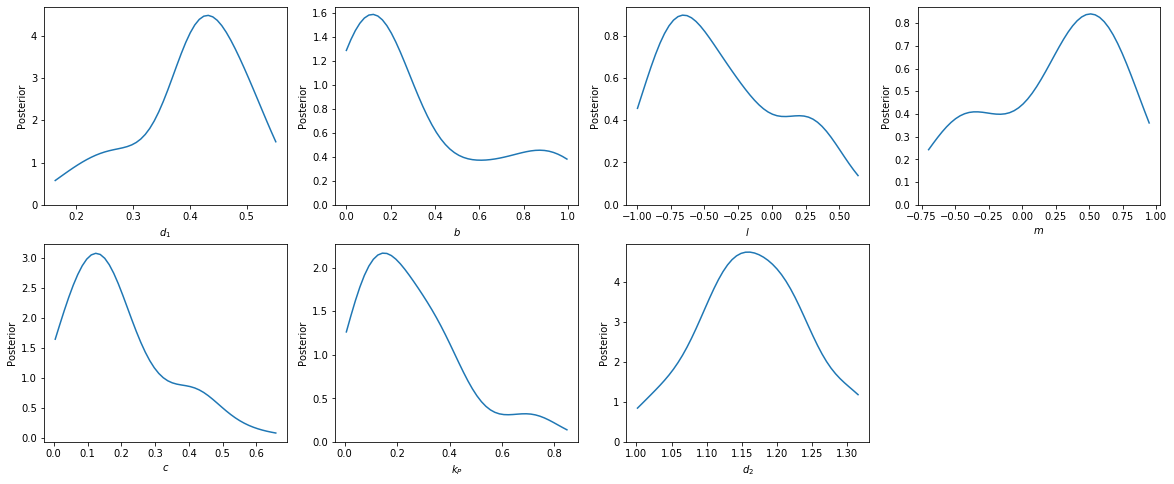

In [13]:
import math
conversion={'at':r'$d_1$','rt':r'$d_2$',
            'ba':r'$b$','bl':r'$l$','bm':r'$m$',
            'ps':r'$k_P$','pi':r'$c$'}
df, w = history.get_distribution(m=0)
result={}
n_paras = len(df.columns)
fig = plt.figure(figsize=[20,8]) 
for index in range(n_paras):
    i = df.columns[index]
    weighted_ave = np.average(df[i],weights=w)
    weighted_var = np.average((np.array(df[i])-weighted_ave)**2,weights=w)
    result[i]=(weighted_ave, weighted_var**0.5)
    ax = fig.add_subplot(math.ceil(n_paras/4),4,index+1)
    pyabc.visualization.plot_kde_1d_highlevel(history, x=i, ax=ax)
    ax.set_xlabel(conversion[i])
print(result)
plt.savefig('estimation pictures/'+'SMM-ABC estimation')
plt.show()

In [14]:
result

{'at': (0.4031094078960007, 0.09415061306485373),
 'ba': (0.31031977275165473, 0.32251897560434445),
 'bl': (-0.3683471793011184, 0.43069782373766796),
 'bm': (0.23941629383902313, 0.46491970510848113),
 'pi': (0.18400479782818133, 0.14005914214511286),
 'ps': (0.24899543348828165, 0.18934808900825545),
 'rt': (1.1663005852416355, 0.07587230310748301)}

In [27]:
paras = (result['at'][0],result['rt'][0],result['ba'][0],result['bm'][0],result['bl'][0],result['ps'][0],1.0,result['pi'][0])
SMM_criterion_2(paras, test_draws, sample_0, Beta_MLE_result_1.x[0], Beta_MLE_result_1.x[1], 1, 'triang', 0, W_identity)

0.32007504520513896